# This notebook will use pyTorch to classify the componentX 
We will use pyTorch and the Transformer architecture to do classifications of the life time for Component X.

In [1]:
#Includes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F


In [2]:
#Read the raw data
#Train data
tteTrain = pd.read_csv('../data/train_tte.csv')
specificationsTrain = pd.read_csv('../data/train_specifications.csv')
readoutsTrain = pd.read_csv('../data/train_operational_readouts.csv')


#Validation data
labelsValidation = pd.read_csv('../data/validation_labels.csv')
specificationsValidation = pd.read_csv('../data/validation_specifications.csv')
readoutsValidation = pd.read_csv('../data/validation_operational_readouts.csv')

#Test data
specificationsTest = pd.read_csv('../data/test_specifications.csv')
readoutsTest = pd.read_csv('../data/test_operational_readouts.csv')
#No labels for test data yet


In [ ]:
#First we group by vehicle_id and we will forward fill the last known value.
#Then if the entire column is NaN, we will fill it with the median of the column. 
#If there are still any NaNs we will fill them with 0.

def fill_missing_values(df):
    df = df.groupby('vehicle_id').apply(lambda x: x.ffill(axis=0)) #Forward fill last known value, but only for the same vehicle
    df = df.droplevel('vehicle_id') #Remove multi-index, as we don't want to group by vehicle_id anymore    
    df = df.fillna(df.median()) #Fill with median rather than mean to avoid outliers
    df = df.fillna(0) #Last resort fill with 0
    
    return df

In [ ]:
#df is the dataframe containing categorical values
#possible_categories is a dictionary with the column name as the key and the possible categories as the values
def one_hot_encoding_fixed_columns(df, possible_categories):
    
    #Create all possible combinations of the columns and categories
    source_columns = list(possible_categories.keys())
    cols = [f'{col}_{cat}' for col in source_columns for cat in possible_categories[col]]
    
    #Create a dataframe with the fixed columns with zeros, using the index of df as the index
    one_hot_encoded = pd.DataFrame(0, index=df.index, columns=cols, dtype=np.float16) 
    
    # Get dummies dataset
    dummies_df = pd.get_dummies(df,columns=source_columns, dtype=np.float16)

    # Make sure columns exists in both dataframes    
    cols_in_both = dummies_df.columns.intersection(cols)

    #Copy the one hot encoded columns to the fixed columns
    one_hot_encoded[cols_in_both] = dummies_df[cols_in_both]

    
    return one_hot_encoded

In [ ]:
def add_features(readoutsdf, specificationsdf):
    df = readoutsdf.copy()

    # Add the specifications of the vehicles
    # We have the specifications of each vehicle. Lets join that to the main table. 
    # Then we will one-hot encode them in order to feed them into a ML model.

    # Join the specifications for the vehicles, then one hot encode the categorical variables
    df = pd.merge(df, specificationsdf, on = 'vehicle_id', how='left')

    # Define possible categories for each column, since the test data may not have all categories
    possible_categories = {
        'Spec_0': ['Cat0', 'Cat1', 'Cat2'],
        'Spec_1': ['Cat0', 'Cat1', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat14', 'Cat15', 'Cat16', 'Cat17', 'Cat18', 'Cat19', 'Cat2', 'Cat20', 'Cat21', 'Cat22', 'Cat23', 'Cat24', 'Cat25', 'Cat26', 'Cat27', 'Cat28', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9'],
        'Spec_2': ['Cat0', 'Cat1', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat14', 'Cat15', 'Cat16', 'Cat17', 'Cat18', 'Cat19', 'Cat2', 'Cat20', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9'],
        'Spec_3': ['Cat0', 'Cat1', 'Cat2', 'Cat3'],
        'Spec_4': ['Cat0', 'Cat1'],
        'Spec_5': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4'],
        'Spec_6': ['Cat0', 'Cat1', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat15', 'Cat17', 'Cat18', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9'],
        'Spec_7': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8']
    }

    # One-hot encode the categorical variables 
    one_hot_encoded = one_hot_encoding_fixed_columns(df, possible_categories)
    
    # Concatenate the one-hot encoded columns with the original DataFrame
    df = pd.concat([df, one_hot_encoded], axis=1)

    #Drop the categorical columns and only keep the one-hot encoded ones
    df = df.drop(columns = list(possible_categories.keys()))

    return df

In [ ]:
df = readoutsTrain.copy()
df = fill_missing_values(df) 
  
#Add features
df = add_features(df, specificationsTrain)

In [ ]:
df.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,Spec_6_Cat9,Spec_7_Cat0,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat3,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,4111.0,1302855.0,1628265.0,630345.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,4111.0,1302855.0,1628265.0,630345.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,4111.0,1302855.0,1628265.0,630345.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# We want to create labels for the training data based on the time to event data
# Labels in validation set are denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively. 
# If we don't have a failure reported, and the time_step left is less 48 we don't know when the failure will happen, so we will label it as -1. 

def get_class_label_train(row):
    #classes denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively
    if row['time_to_potential_event'] > 48:
        return 0 #No failure within 48 time steps
    elif row['time_to_potential_event'] > 24 and row['in_study_repair'] == 1:
        return 1 #Failure within 48 to 24 time steps
    elif row['time_to_potential_event'] > 12 and row['in_study_repair'] == 1:
        return 2 #Failure within 24 to 12 time steps
    elif row['time_to_potential_event'] > 6 and row['in_study_repair'] == 1:
        return 3 #Failure within 12 to 6 time steps
    elif row['time_to_potential_event'] > 0 and row['in_study_repair'] == 1:
        return 4 #Failure within 6 to 0 time steps
    else:
        return -1 #No failure reported, but within 48 time steps from the end of the study, don't know if it will fail or not
    
def add_class_labels_train(ttedf, readoutsdf):
    # Join the readouts and the time to event data
    df = pd.merge(readoutsdf, ttedf, on = 'vehicle_id', how='left').copy()

    #Calculate the time to a failure event
    df['time_to_potential_event'] = df['length_of_study_time_step'] - df['time_step']

    df['class_label'] = df.apply(get_class_label_train, axis=1)

    return df

In [ ]:
# We want to create labels for the training data based on the time to event data
# Labels in validation set are denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively. 
# The validation_labels.csv file has 5046 rows, which is equal to the number of vehicles contributed to the operational data of the
# validation set. It includes a column named class_label, corresponding to the class for the last readout of each vehicle.
# As mentioned in subsection validation_operational_readouts.csv, the last readout for the validation set is selected randomly
# among all readouts for each vehicle. The temporal placement of this final simulated readout is categorized into five classes
# denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12
# to 6), and (6 to 0) time_step before the failure, respectively. These classes show the time windows in which the last readouts for
# each vehicle are randomly selected.

def get_class_label_validation(row):
    #classes denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively
    dt = row['time_to_potential_event'] #Time left to the end of the time series

    #Add time based on the class_labels
    if row['class_label'] == 0:
        #(48+) after last readout
        dt += 48
    elif row['class_label'] == 1:
        #(48 to 24) after last readout
        dt += 24
    elif row['class_label'] == 2:
        #(24 to 12) after last readout
        dt += 12
    elif row['class_label'] == 3:
        #(12 to 6) after last readout
        dt += 6
    elif row['class_label'] == 4:
        #(6 to 0) after last readout
        dt += 0


    if dt >= 48:
        return 0 #No failure within 48 time steps
    elif dt >= 24:
        return 1 #Failure within 48 to 24 time steps
    elif dt >= 12:
        return 2 #Failure within 24 to 12 time steps
    elif dt >= 6:
        return 3 #Failure within 12 to 6 time steps
    elif dt >= 0:
        return 4 #Failure within 6 to 0 time steps
    else:
        return -1 #Should not happen...
    
def add_class_labels_validation(ttedf, readoutsdf):
    # Join the readouts and the time to event data
    df = pd.merge(readoutsdf, ttedf, on = 'vehicle_id', how='left').copy()

    # For each vehicle get the max time_step seen for that vehicle:
    df['length_of_study_time_step'] = df.groupby('vehicle_id')['time_step'].transform('max')

    #Calculate the time to a failure event
    df['time_to_potential_event'] = df['length_of_study_time_step'] - df['time_step']

    df['class_label'] = df.apply(get_class_label_validation, axis=1)

    return df

In [ ]:
#This function will preprocess all the data step by step and return X and y
def preprocess_all(readoutsdf, specificationsdf, ttedf=None, validation=False):
    #Fill missing values
    df = fill_missing_values(readoutsdf) 
  
    #Add features
    df = add_features(df, specificationsdf)

    #We only have information about the class labels in the training and validation data
    if ttedf is not None:

        #Merge the time to event data with the readouts data and figure out which class they belong to
        #Later we will need to remove the columns: length_of_study_time_step, in_study_repair, time_to_potential_event, class_label and remove any rows with class label -1

        #Train and validation targets are structured in different ways, needs to be handled differently
        if validation:
            df = add_class_labels_validation(ttedf, df)
            #Drop the columns that we cannot use for training, since they contain information about the class label
            df = df.drop(columns = ['length_of_study_time_step', 'time_to_potential_event'])
        else:
            df = add_class_labels_train(ttedf, df)
            #Drop the columns that we cannot use for training, since they contain information about the class label
            df = df.drop(columns = ['length_of_study_time_step', 'in_study_repair', 'time_to_potential_event'])

        # Remove classes with class -1, where we don't know if the vehicle will fail or not within 48 hours
        df = df[df['class_label'] != -1]
  

    return df

In [ ]:
dfTrain = preprocess_all(readoutsTrain, specificationsTrain, tteTrain, validation=False)
dfValidation = preprocess_all(readoutsValidation, specificationsValidation, labelsValidation, validation=True)
dfTest = preprocess_all(readoutsTest, specificationsTest)
#dfTrain, XTrain, yTrain = preprocess_all(readoutsTrain, specificationsTrain, tteTrain, validation=False)
# XValidation, yValidation = preprocess_all(readoutsValidation, specificationsValidation, labelsValidation, validation=True)
# XTest, yTest = preprocess_all(readoutsTest, specificationsTest)

In [ ]:
dfTrain.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,Spec_7_Cat0,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat3,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8,class_label
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,4111.0,1302855.0,1628265.0,630345.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,4111.0,1302855.0,1628265.0,630345.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,4111.0,1302855.0,1628265.0,630345.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# Use Scikit-learn to normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#Normalize the data, but only the columns that are not one hot encoded
colsToIgnore = ['vehicle_id', 'class_label', 'Spec']
#Get the columns that we don't ignore
columns = [col for col in dfTrain.columns if all(ignored not in col for ignored in colsToIgnore)]

#Fit and transform the data
dfTrain[columns] = scaler.fit_transform(dfTrain[columns])

#Use the same transformation for the validation and test data
dfValidation[columns] = scaler.transform(dfValidation[columns])
dfTest[columns] = scaler.transform(dfTest[columns])

In [ ]:
dfValidation.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,Spec_7_Cat0,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat3,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8,class_label
0,10,-1.401526,-1.174908,-0.792514,-1.215986,-0.519401,-0.275722,-1.123193,-1.054025,-0.895208,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,10,-1.350937,-1.143335,-0.694372,-1.167848,-0.475053,-0.275722,-1.049603,-1.033836,-0.880753,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,10,-1.344038,-1.136706,-0.672664,-1.158933,-0.467178,-0.275722,-1.045711,-1.029650,-0.879821,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,10,-1.298048,-1.119632,-0.637477,-1.137810,-0.436923,-0.207791,-1.009742,-1.020041,-0.875221,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,10,-1.295749,-1.119626,-0.637477,-1.137810,-0.436923,-0.207791,-1.009742,-1.020041,-0.875221,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# Group by vechicle_id and get the last target_value for each vehicle, this is now our y
yTrain = dfTrain.groupby('vehicle_id').last()['class_label']
yValidation = dfValidation.groupby('vehicle_id').last()['class_label']
#No target for test data

#For each vechicle_id create a matrix of all the features in order of time_step
#This will be our X
XTrain = dfTrain.drop(columns=['class_label']).groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)
XValidation = dfValidation.drop(columns=['class_label']).groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)

#No class label for test data
XTest = dfTest.groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)

#Convert to numpy arrays
XTrain = np.array(XTrain)
XValidation = np.array(XValidation)
XTest = np.array(XTest)

In [ ]:
# We want to create feature inputs for the torch model
# Shape should be (n_vehicles, n_timesteps, n_features)
# We need to pad the sequences with zeros to make them the same length
def pad_sequences(X, max_length=256):
    
    #Create a tensor for the sequences
    X_padded = np.zeros((len(X), max_length, X[0].shape[1]), dtype=np.float32)

    #Pad the sequences with zeros
    for i, x in enumerate(X):
        length = x.shape[0]
        X_padded[i, :length] = x[-max_length:] #Only keep the last max_length time steps    

    return X_padded

In [ ]:
max_length = 256
XPaddedTrain = pad_sequences(XTrain, max_length=max_length)
XPaddedValidation = pad_sequences(XValidation, max_length=max_length)
XPaddedTest = pad_sequences(XTest, max_length=max_length)

In [ ]:
#Convert to tensors
XTrain = torch.tensor(XPaddedTrain, dtype=torch.float32)
yTrain = torch.tensor(yTrain.values, dtype=torch.int64)

XValidation = torch.tensor(XPaddedValidation, dtype=torch.float32)
yValidation = torch.tensor(yValidation.values, dtype=torch.int64)

XTest = torch.tensor(XPaddedTest, dtype=torch.float32)


In [ ]:
XTrain.shape

torch.Size([23549, 256, 196])

In [ ]:
# Create a pyTorch Transformer model that takes a sequence of features and outputs a class label
# The model should not have an embedding layer, rather the features should be used directly one for each position
# The input should be of shape (batch_size, sequence_length, n_features)
# The position of the features should be encoded using positional encoding


class XTransformer(nn.Module):
    def __init__(self, n_features, n_classes, n_layers=6, n_heads=8, max_time_steps=256, hidden_size=512, dropout=0.1, dim_feedforward=2048):
        super(XTransformer, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.max_time_steps = max_time_steps
        self.dim_feedforward = dim_feedforward
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.dropout_layer = nn.Dropout(dropout)
 
        self.input_layer = nn.Linear(n_features, hidden_size)
        # Positional embedding
        self.position_embedding = nn.Embedding(max_time_steps, embedding_dim=hidden_size)
        
        self.layer_norm1 = nn.LayerNorm(n_features)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_size, 
                nhead=n_heads, 
                dropout=dropout,
                dim_feedforward=dim_feedforward,
                batch_first=True
                ) for _ in range(n_layers)])

        # Output layer
        self.output_layer = nn.Linear(hidden_size, n_classes)

    def forward(self, x):

        B, T, C = x.shape

        device = x.device   

        # Input layer, normalize and apply dropout
        x = self.layer_norm1(x)
        x = self.dropout_layer(x)

        #FC layer, to get to the correct hidden size
        x = self.input_layer(x)

        # Add positional encoding
        position_ids = torch.arange(T, device=device).unsqueeze(0).repeat(B, 1)  # Expand to batch size
        pos_emb = self.position_embedding(position_ids)  # (B, T, hidden_size)
        x = x + pos_emb #(B, T, C)

        #Dropout
        x = self.dropout_layer(x)

        # Transformer layers
        for layer in self.transformer_layers:
            x = layer(x)


        # Normalize and apply dropout
        x = self.layer_norm2(x)
        
        #Dropout
        x = self.dropout_layer(x)
        
        # Output layer
        x = self.output_layer(x)

        # Only keep the last time step
        #x = x.mean(dim=1).squeeze()
        x = x[:, -1, :].squeeze()

        return x


In [ ]:
yTrain.unique()

tensor([0, 1, 2, 3, 4])

In [ ]:
# Get the current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda


In [ ]:
XTrain.shape

torch.Size([23549, 256, 196])

In [ ]:
#model = XTransformer(n_features=XTrain.shape[2], n_classes=5, dropout=0.1, n_layers=3, n_heads=8, max_time_steps=XTrain.shape[1], hidden_size=512, dim_feedforward=2048)
model = XTransformer(n_features=XTrain.shape[2], n_classes=5, dropout=0.2, n_layers=3, n_heads=8, max_time_steps=XTrain.shape[1], hidden_size=512, dim_feedforward=2048)

In [ ]:
#Send model to device
model = model.to(device)


# Create weighted samples
We need to train the model on a balanced training set, in order to minimize mitigate the effect of inbalance.


In [ ]:
# Batch the data
batch_size = 1024
#batch_size = 5*100
num_workers = 6


#Calculate the class weights
class_weights = 1.0 / torch.tensor([len(yTrain[yTrain == i]) for i in range(5)], dtype=torch.float32, device=device)

# Create a sampler for the data
weights = class_weights[yTrain]
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

train_data = torch.utils.data.TensorDataset(XTrain, yTrain)

# Create a DataLoader that samples from the WeightedRandomSampler
train_loader= torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=num_workers)

#Same for validation data, but without the weighted classes
validation_data = torch.utils.data.TensorDataset(XValidation, yValidation)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
# # Get a mini batch
# num_workers = 6
# XMini, yMini = next(iter(train_loader))
# #Creata a train_data with mini-data
# #mini_batch_size = 512
# train_data_mini = torch.utils.data.TensorDataset(XMini, yMini)
# train_loader_mini = torch.utils.data.DataLoader(train_data_mini, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# train_loader = train_loader_mini
# #validation_loader = train_loader_mini

In [ ]:
# # Get a mini validation loader too

# #Calculate the class weights
# class_weights = 1.0 / torch.tensor([len(yValidation[yValidation == i]) for i in range(5)], dtype=torch.float32, device=device)

# # Create a sampler for the data
# weights = class_weights[yValidation]
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

# validation_data = torch.utils.data.TensorDataset(XValidation, yValidation)

# # Create a DataLoader that samples from the WeightedRandomSampler
# train_loader_mini= torch.utils.data.DataLoader(validation_data, batch_size=batch_size, sampler=sampler)

# XValMini, yValMini = next(iter(train_loader_mini))


# validation_data_mini = torch.utils.data.TensorDataset(XValMini, yValMini)
# train_loader_mini = torch.utils.data.DataLoader(validation_data_mini, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# validation_loader = train_loader_mini
# plt.hist(np.array(yMini),5)

In [ ]:
# Define the loss function and optimizer
# We need to weight the classes since they are imbalanced
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
#Find the class weights
#class_weights = 1.0 / torch.tensor([len(yTrain[yTrain == i]) for i in range(5)], dtype=torch.float32, device=device)


# classes = np.unique(np.array(yTrain))
# # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.array(yTrain))

# class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)


#Create a optimizer and loss function
#criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss() #We will use class weights when sampling the data instead
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.05)

#Create a loss function for the validation data
class_weights_val = 1.0 / torch.tensor([len(yValidation[yValidation == i]) for i in range(5)], dtype=torch.float32, device=device)
criterion_val = nn.CrossEntropyLoss(weight=class_weights_val)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
loss_train = []
loss_validation = []
epochs = 25
checkpoint_path = 'model3.pth'
best_validation_loss = 1e9
clip_value = 1.0  # Define the clip value for gradient clipping


In [ ]:
# Create a training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_validation = 0
    total_validation = 0


    # Setup tqdm progress bar for the training loop
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Training]', leave=False)
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        #Add noise to the inputs for regularization purposes
        inputs = inputs + torch.randn_like(inputs, device=device) * 0.01

        #Forward pass
        outputs = model(inputs)

        #Calculate the loss
        loss = criterion(outputs, labels)

        #Zero the gradients
        optimizer.zero_grad()

        #Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        #Update the parameters
        optimizer.step()

        running_loss += loss.item()

        #Calculate the accuracy:
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        correct_train += correct
        total_train += total
        accuracy_train = correct_train / total_train

        train_progress_bar.set_postfix({'loss': (running_loss / (train_progress_bar.n + 1)), 'accuracy train': accuracy_train})
        train_progress_bar.update()
        
    loss_train.append(running_loss / len(train_loader))

    
    # Validation loss
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(validation_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion_val(outputs, labels) #Use the validation loss function, which has class weights

            running_loss += loss.item()
             #Calculate the accuracy:
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            correct_validation += correct
            total_validation+= total

    loss_validation.append(running_loss / len(validation_loader))
    accuracy_validation = correct_validation / total_validation
    accuracy_train = correct_train / total_train

    #Save the model if it is the best one so far
    if loss_validation[-1] < best_validation_loss:
        print(f'Saving model with validation loss {loss_validation[-1]:.4f}')
        torch.save(model.state_dict(), checkpoint_path)
        best_validation_loss = loss_validation[-1]


    print(f'Epoch {epoch + 1}, loss_train: {loss_train[-1]:.4f}, loss_validation: {loss_validation[-1]:.4f}, accuracy_train: {accuracy_train:.4f}, accuracy_validation: {accuracy_validation:.4f}')
    #Close the progress bar
    
    train_progress_bar.close()
    # Step the scheduler
    scheduler.step()

Epoch 1/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Saving model with validation loss 1.6262
Epoch 1, loss_train: 1.7425, loss_validation: 1.6262, accuracy_train: 0.2561, accuracy_validation: 0.1657


Epoch 2/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2, loss_train: 1.3580, loss_validation: 2.0974, accuracy_train: 0.4105, accuracy_validation: 0.1536


Epoch 3/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3, loss_train: 1.1350, loss_validation: 2.6774, accuracy_train: 0.5289, accuracy_validation: 0.1013


Epoch 4/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4, loss_train: 1.0131, loss_validation: 2.8824, accuracy_train: 0.5790, accuracy_validation: 0.1292


Epoch 5/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5, loss_train: 0.8745, loss_validation: 3.1431, accuracy_train: 0.6354, accuracy_validation: 0.2190


Epoch 6/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6, loss_train: 0.7579, loss_validation: 3.2181, accuracy_train: 0.6906, accuracy_validation: 0.1417


Epoch 7/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7, loss_train: 0.7237, loss_validation: 3.3765, accuracy_train: 0.7026, accuracy_validation: 0.1514


Epoch 8/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8, loss_train: 0.7088, loss_validation: 3.4205, accuracy_train: 0.7092, accuracy_validation: 0.1556


Epoch 9/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9, loss_train: 0.6807, loss_validation: 3.5359, accuracy_train: 0.7188, accuracy_validation: 0.1845


Epoch 10/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10, loss_train: 0.6664, loss_validation: 3.7111, accuracy_train: 0.7279, accuracy_validation: 0.1538


Epoch 11/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11, loss_train: 0.6592, loss_validation: 3.6437, accuracy_train: 0.7320, accuracy_validation: 0.1865


Epoch 12/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12, loss_train: 0.6465, loss_validation: 3.6594, accuracy_train: 0.7320, accuracy_validation: 0.1855


Epoch 13/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13, loss_train: 0.6531, loss_validation: 3.6685, accuracy_train: 0.7337, accuracy_validation: 0.1829


Epoch 14/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14, loss_train: 0.6426, loss_validation: 3.6419, accuracy_train: 0.7406, accuracy_validation: 0.1797


Epoch 15/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 15, loss_train: 0.6364, loss_validation: 3.6743, accuracy_train: 0.7374, accuracy_validation: 0.1792


Epoch 16/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 16, loss_train: 0.6405, loss_validation: 3.6723, accuracy_train: 0.7374, accuracy_validation: 0.1815


Epoch 17/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 17, loss_train: 0.6507, loss_validation: 3.6731, accuracy_train: 0.7338, accuracy_validation: 0.1807


Epoch 18/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 18, loss_train: 0.6574, loss_validation: 3.6742, accuracy_train: 0.7273, accuracy_validation: 0.1809


Epoch 19/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 19, loss_train: 0.6369, loss_validation: 3.6776, accuracy_train: 0.7409, accuracy_validation: 0.1813


Epoch 20/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 20, loss_train: 0.6428, loss_validation: 3.6716, accuracy_train: 0.7399, accuracy_validation: 0.1855


Epoch 21/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 21, loss_train: 0.6439, loss_validation: 3.6725, accuracy_train: 0.7340, accuracy_validation: 0.1855


Epoch 22/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 22, loss_train: 0.6413, loss_validation: 3.6738, accuracy_train: 0.7362, accuracy_validation: 0.1849


Epoch 23/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 23, loss_train: 0.6430, loss_validation: 3.6745, accuracy_train: 0.7357, accuracy_validation: 0.1849


Epoch 24/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 24, loss_train: 0.6429, loss_validation: 3.6751, accuracy_train: 0.7383, accuracy_validation: 0.1849


Epoch 25/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 25, loss_train: 0.6348, loss_validation: 3.6763, accuracy_train: 0.7391, accuracy_validation: 0.1847


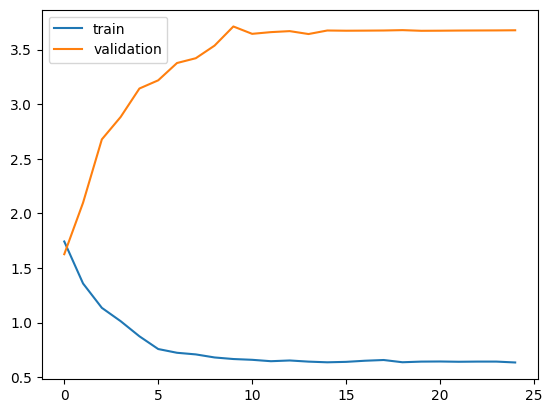

In [ ]:
# Plot the loss
plt.plot(loss_train, label='train')
plt.plot(loss_validation, label='validation')
plt.legend()
plt.show()


# Create predictions

In [ ]:
# Create a function that takes the model, data loader and device and returns the predictions
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)

            outputs = model(inputs)
            outputs = outputs.argmax(dim=1).cpu().numpy() #Take the class with the highest probability
            predictions.append(outputs)
            targets.append(labels.numpy())

    return np.concatenate(predictions), np.concatenate(targets)

In [ ]:
# Create a diffusion matrix of the train and validation data

yPredTrain, yTrainNp = get_predictions(model, train_loader, device)
yPredValidation, yValidationNp = get_predictions(model, validation_loader, device)

In [ ]:
yPredValidation.shape

(5046,)

In [ ]:
from sklearn.metrics import classification_report

#Print the classification report
print('Training data:')
print(classification_report(yTrainNp, yPredTrain))

print('Validation data:')
print(classification_report(yValidationNp, yPredValidation))


Training data:
              precision    recall  f1-score   support

           0       0.61      0.46      0.52      4548
           1       0.95      1.00      0.97      4705
           2       0.87      1.00      0.93      4667
           3       0.69      0.74      0.71      4779
           4       0.61      0.58      0.60      4850

    accuracy                           0.76     23549
   macro avg       0.75      0.76      0.75     23549
weighted avg       0.74      0.76      0.75     23549

Validation data:
              precision    recall  f1-score   support

           0       0.99      0.18      0.31      4910
           1       0.00      0.06      0.00        16
           2       0.00      0.07      0.00        14
           3       0.01      0.57      0.01        30
           4       0.02      0.21      0.04        76

    accuracy                           0.18      5046
   macro avg       0.21      0.22      0.07      5046
weighted avg       0.97      0.18      0.30  

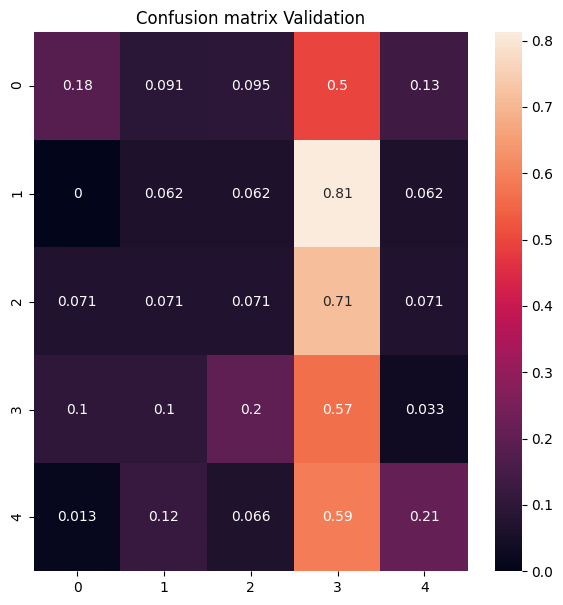

In [ ]:
#Import confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yValidationNp, yPredValidation, normalize='true')
plt.figure(figsize = (7,7))
#add labels
plt.title('Confusion matrix Validation')
plt.xlabel('Predicted')
plt.ylabel('True')
#plot the confusion matrix
ax = sns.heatmap(cm, annot=True)

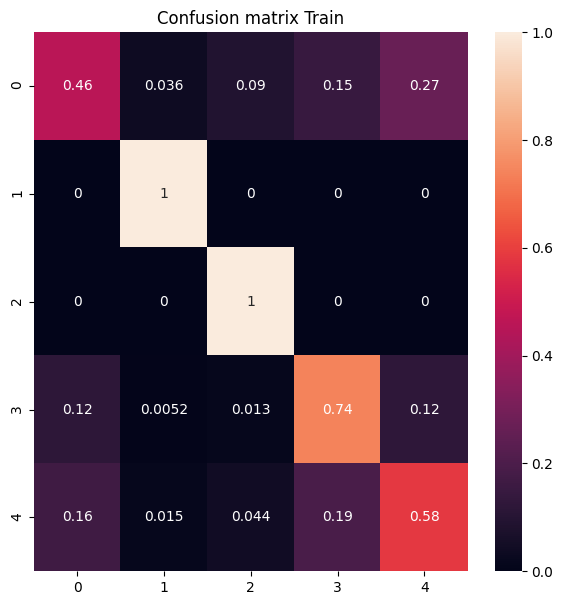

In [ ]:
cm = confusion_matrix(yTrainNp, yPredTrain, normalize='true')
plt.figure(figsize = (7,7))
#add labels
plt.title('Confusion matrix Train')
plt.xlabel('Predicted')
plt.ylabel('True')
#plot the confusion matrix
ax = sns.heatmap(cm, annot=True)

In [ ]:
checkpoint_path = 'model3.pth'

In [ ]:
#Clone the latest model
import copy
model_latest = copy.deepcopy(model)

In [ ]:
#Load the best model
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [ ]:
model.to(device)

XTransformer(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (input_layer): Linear(in_features=196, out_features=512, bias=True)
  (position_embedding): Embedding(256, 512)
  (layer_norm1): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (transformer_layers): ModuleList(
    (0-2): 3 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (linear2): Linear(in_features=2048, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Linear(in

In [ ]:
from torchinfo import summary
summary(model, (2, XTrain.shape[1], XTrain.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
XTransformer                             [2, 5]                    --
├─LayerNorm: 1-1                         [2, 256, 196]             392
├─Dropout: 1-2                           [2, 256, 196]             --
├─Linear: 1-3                            [2, 256, 512]             100,864
├─Embedding: 1-4                         [2, 256, 512]             131,072
├─Dropout: 1-5                           [2, 256, 512]             --
├─ModuleList: 1-6                        --                        --
│    └─TransformerEncoderLayer: 2-1      [2, 256, 512]             3,152,384
│    └─TransformerEncoderLayer: 2-2      [2, 256, 512]             3,152,384
│    └─TransformerEncoderLayer: 2-3      [2, 256, 512]             3,152,384
├─LayerNorm: 1-7                         [2, 256, 512]             1,024
├─Dropout: 1-8                           [2, 256, 512]             --
├─Linear: 1-9                            [2, 256, 

In [ ]:
XTrain[:1,0,:]

tensor([[-1.3072, -1.1273, -0.7391, -1.1580, -0.5077, -0.1702, -0.9152, -0.9577,
         -0.8545, -0.8262, -1.1424, -0.5975, -0.3409, -0.1994, -0.1135, -0.1502,
         -0.9025, -0.8762, -0.6149, -0.4785, -1.0147, -0.4707, -0.1609, -0.0617,
         -0.0565, -0.0545, -1.1793, -0.3354, -0.0559, -0.0099, -0.0067, -0.7657,
         -0.5794, -0.3132, -0.1320, -0.0420, -0.0187, -0.0191, -0.0078, -0.7432,
         -1.1875, -1.1341, -1.0226, -1.0457, -0.9844, -0.9252, -0.8589, -0.6760,
         -0.3848, -0.9631, -0.6579, -0.7007, -0.8898, -0.8436, -0.8188, -0.7907,
         -0.8033, -0.8110, -0.8420, -0.8709, -0.8625, -0.8589, -0.8408, -0.6987,
         -0.7025, -0.8920, -0.3297, -0.0223, -0.0312, -0.0126, -0.0767, -0.2012,
         -0.0363, -0.0371, -0.0108, -0.3804, -0.0283, -0.0319, -0.3025, -0.0088,
         -0.0076, -0.0065, -0.0129, -0.1194, -0.0427, -0.0163, -0.0120, -0.0196,
         -0.4979, -0.0467, -0.9211, -0.0180, -0.0068, -0.0064, -0.1815, -0.6756,
         -0.9085, -0.2720, -

In [ ]:
Xbatch = XTrain[:1, :, :]
#Add noise to the input
Xbatch = Xbatch + torch.randn_like(Xbatch) * 0.01

In [ ]:
Xbatch[:1,0,:]

tensor([[-1.3267e+00, -1.1944e+00, -8.3317e-01, -1.2592e+00, -6.2155e-01,
         -2.8731e-01, -8.2699e-01, -8.0758e-01, -7.7688e-01, -7.9297e-01,
         -1.2220e+00, -4.4714e-01, -1.1961e-01, -2.7579e-01,  2.5382e-02,
         -1.5561e-01, -9.2952e-01, -1.0014e+00, -6.5453e-01, -3.9136e-01,
         -7.8352e-01, -3.8433e-01, -2.0759e-01, -2.3543e-01, -2.4767e-01,
         -1.5774e-01, -1.2020e+00, -2.2190e-01, -1.8582e-01, -5.9130e-02,
          1.7118e-01, -7.4520e-01, -6.6385e-01, -4.4410e-02,  3.7261e-02,
          1.7731e-02, -7.8666e-02, -1.0866e-01,  3.1369e-02, -6.8034e-01,
         -1.2918e+00, -1.1383e+00, -1.0352e+00, -9.6814e-01, -1.1047e+00,
         -9.5862e-01, -8.5881e-01, -6.7879e-01, -5.0567e-01, -1.0521e+00,
         -8.4914e-01, -6.5407e-01, -9.6427e-01, -9.7646e-01, -1.0625e+00,
         -7.3236e-01, -1.0257e+00, -7.7528e-01, -8.8715e-01, -9.3012e-01,
         -8.7049e-01, -9.1877e-01, -8.9547e-01, -8.3779e-01, -8.3228e-01,
         -9.4950e-01, -4.6091e-01, -1.